## Convocatoria 1 - Proyecto 1
**Estudiante:** Velasteguí Izurieta Homero Javier

#### **Importación de Librerías Utilizadas**

In [1]:
# Importar librerías necesarias
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import binary_fill_holes
from scipy.spatial import ConvexHull
import seaborn as sns
from skimage import io
from skimage.draw import disk
from skimage.filters import threshold_otsu, gaussian, threshold_otsu
from skimage.measure import find_contours, regionprops, label, regionprops
from skimage.morphology import convex_hull_image, remove_small_objects
from skimage.segmentation import flood
from skimage.transform import resize


# Cargar una de las imágenes histológicas

En este paso se realiza la carga inicial de una de las imágenes histológicas (`histo_1.jpg`) utilizando la librería `skimage.io`. Luego, se normalizan los valores de los píxeles para que se encuentren en el rango `[0, 1]`, lo cual es una práctica común en procesamiento de imágenes, ya que facilita la posterior aplicación de algoritmos de visión artificial.

Además, se visualiza la imagen original para confirmar que la carga y normalización se realizaron correctamente.

#### Acciones realizadas:

- Lectura de la imagen en formato RGB (color).
- Normalización de los valores de los píxeles mediante la fórmula:

  $$
  \text{imagen\_normalizada} = \frac{\text{imagen} - \min(\text{imagen})}{\max(\text{imagen}) - \min(\text{imagen})}
  $$

- Visualización de la imagen normalizada mediante `matplotlib`.

> Nota: Esta normalización asegura que todos los valores estén entre 0 y 1, incluso si la imagen original no usa el rango completo de 0 a 255.

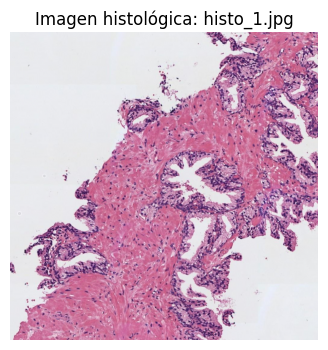

In [2]:
# Utilizar la librería skimage.io para leer la imagen 'histo_x.jpg' en formato RGB.
# Normalizar la imagen para que los píxeles se encuentren en el rango [0, 1]
# Visualizar la imagen

# Leer la imagen histológica en formato RGB
imagen = io.imread('histo_1.jpg')

# Convertir los valores de píxeles al rango [0, 1]
imagen = (imagen- imagen.min()) / (imagen.max()-imagen.min())

# Mostrar la imagen
plt.figure(figsize=(4, 4))
plt.imshow(imagen)
plt.axis('off')  # Ocultar ejes para una mejor visualización
plt.title('Imagen histológica: histo_1.jpg')
plt.show()


# Realizar una transformación de color para convertir la imagen al espacio de color CMYK

El objetivo de este paso es resaltar la **región tisular** (tejido teñido) de la imagen histológica, que se encuentra mejor representada por la componente **magenta** en el espacio de color **CMYK**. Dado que `scikit-image` no tiene soporte nativo para CMYK, se realiza una conversión aproximada a partir del modelo RGB.

#### Conversión aproximada RGB → CMYK:

Dado que la imagen está normalizada en el rango [0, 1], la componente magenta se puede obtener de forma simple mediante la inversión del canal verde (G), ya que:

$$
\text{Magenta} = 1 - \text{Verde}
$$

Este método permite extraer de manera efectiva las regiones del tejido que están coloreadas intensamente, lo cual es útil para pasos posteriores de segmentación.

#### Acciones realizadas:

- Conversión conceptual de RGB a CMYK simulando:  
  - `Magenta = 1 - imagen[:, :, 1]` (donde `imagen[:, :, 1]` es el canal verde).
- Visualización del canal magenta en escala de grises para analizar su distribución espacial.

> La componente magenta ayuda a destacar las zonas más relevantes del tejido (núcleos, lumen, estroma), ya que es sensible a los tintes utilizados en las muestras histológicas.


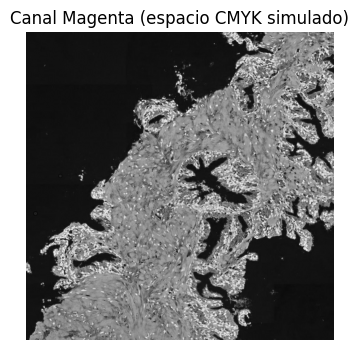

In [3]:
# Extraer la componente magenta de la imagen (que corresponde a la región tisular)
# Visualizar la imagen del canal magenta

# Se asume que `imagen` está normalizada en el rango [0, 1] y tiene 3 canales (RGB)

# Extraer la componente magenta (aproximación CMYK)
canal_magenta = 1 - imagen[:, :, 1]  # Invertimos el canal verde (G)

# Visualizar el canal magenta
plt.figure(figsize=(4, 4))
plt.imshow(canal_magenta, cmap='gray')  # Usamos escala de grises
plt.axis('off')
plt.title('Canal Magenta (espacio CMYK simulado)')
plt.show()


## Alternativa: Conversión RGB → CMYK usando Pillow

Aunque `scikit-image` no proporciona soporte directo para el espacio de color CMYK, es posible utilizar la biblioteca `Pillow` para realizar una conversión más precisa al modelo de color **CMYK**, como se haría en un entorno profesional de procesamiento de imágenes.

Esto permite extraer de forma nativa el canal **Magenta**, que resulta útil para resaltar las
regiones tisulares teñidas de las imágenes histológicas.

#### Acciones realizadas:

- Se utiliza la biblioteca `Pillow` (`PIL`) para cargar la imagen y convertirla directamente al espacio CMYK.
- Se extrae el canal **Magenta** (`M`) del objeto CMYK generado por `Pillow`.
- Se normaliza el canal magenta a valores `[0, 1]` para una correcta visualización con `matplotlib`.
- Se visualiza el canal magenta utilizando.

#### Comparación con la conversión manual:

En el método anterior se estimó el canal magenta como:

$$
\text{Magenta} \approx 1 - \text{G}
$$

Aunque esta aproximación es útil y computacionalmente eficiente, el uso de `Pillow` permite contrastar los resultados con una conversión basada en el modelo CMYK estándar, lo que puede ser beneficioso para validar visualmente si el canal extraído resalta adecuadamente las regiones de interés.

> 🧪 Esta comparación es especialmente útil para verificar si la aproximación con `1 - G` es suficiente en esta tarea, o si se requieren métodos más precisos dependiendo del contexto.


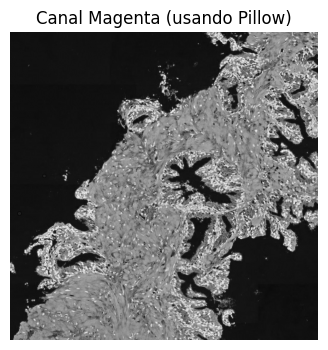

In [4]:
# Cargar imagen original con Pillow
imagen_pil = Image.open('histo_1.jpg')

# Convertir a CMYK
imagen_cmyk = imagen_pil.convert('CMYK')

# Separar los canales CMYK
C, M, Y, K = imagen_cmyk.split()

# Convertir el canal magenta a NumPy array para visualizar
magenta_np = np.array(M) / 255.0  # Normalizar para visualizar

# Visualizar canal magenta
plt.figure(figsize=(4, 4))
plt.imshow(magenta_np, cmap='gray')
plt.axis('off')
plt.title('Canal Magenta (usando Pillow)')
plt.show()


## Comparación visual: Diferencia entre canal Magenta estimado y real

Con el objetivo de analizar la similitud entre la conversión manual del canal Magenta (`1 - G`) y la conversión realizada con `Pillow` al modelo CMYK, se realiza una comparación pixel a pixel mediante la diferencia absoluta entre ambos canales.

#### Procedimiento:

1. Se asegura que ambos canales (`canal_magenta` y `magenta_np`) tengan las mismas dimensiones. Si no es así, se aplica un `resize` al canal de Pillow para igualarlos.
2. Se calcula la diferencia absoluta:

   $$
   \text{diferencia}(i,j) = \left| \text{magenta}_{\text{manual}}(i,j) - \text{magenta}_{\text{Pillow}}(i,j) \right|
   $$

3. Se visualiza la imagen de diferencias en escala de colores (`hot`) para detectar zonas con discrepancia.

#### Interpretación:

- **Zonas oscuras**: Alta similitud entre ambos métodos.
- **Zonas blancas**: Discrepancias notables que podrían impactar en pasos posteriores como segmentación o extracción de características.

> Este análisis permite validar si la conversión manual es suficientemente precisa para la tarea o si conviene utilizar la conversión nativa a CMYK cuando se requiera mayor fidelidad de color.

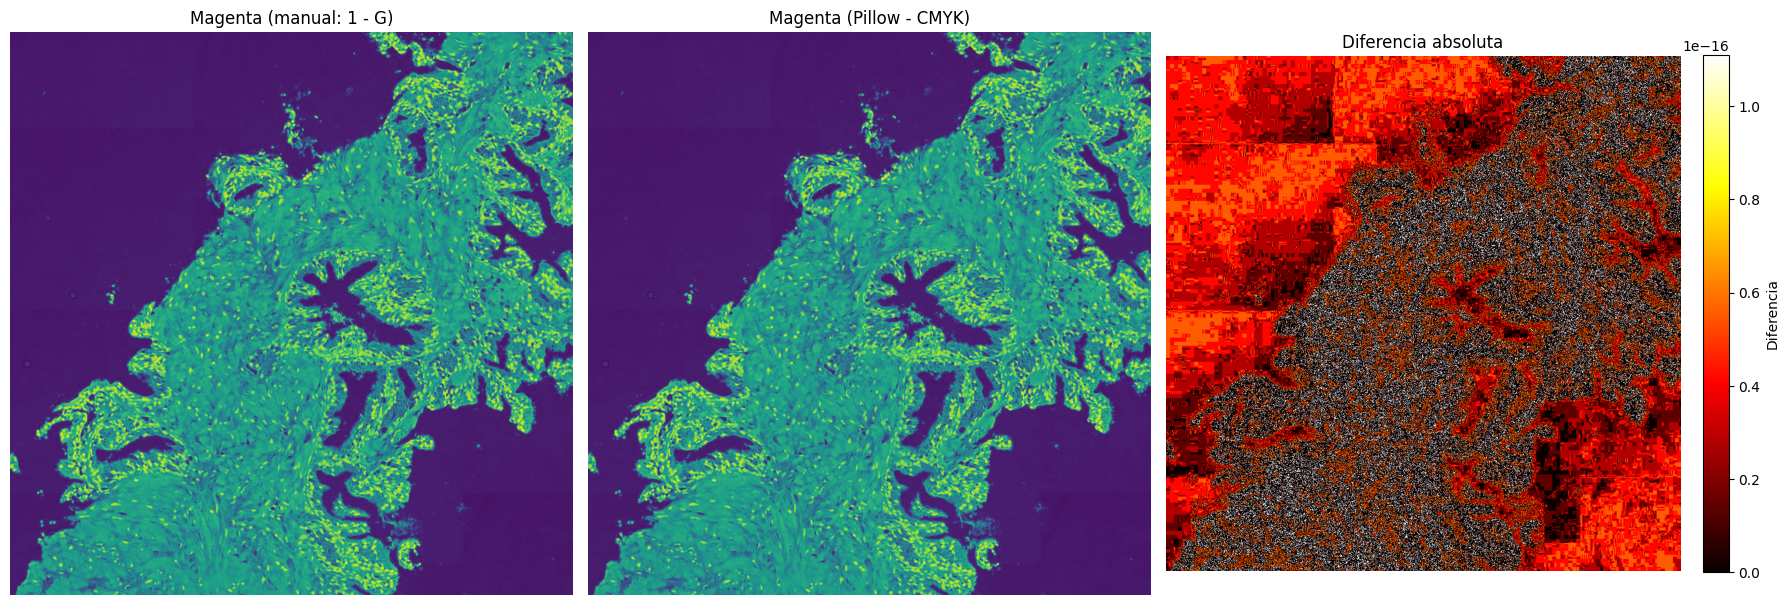

In [5]:

# Asegurar que ambas imágenes tengan el mismo tamaño
if canal_magenta.shape != magenta_np.shape:
    magenta_np_resized = resize(magenta_np, canal_magenta.shape, anti_aliasing=True)
    print("Imagen Redimensionada")
else:
    magenta_np_resized = magenta_np

# Calcular diferencia absoluta
diferencia = np.abs(canal_magenta - magenta_np_resized)

# Crear subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Imagen 1: Magenta estimado manualmente (1 - G)
axs[0].imshow(canal_magenta)
axs[0].set_title("Magenta (manual: 1 - G)")
axs[0].axis('off')

# Imagen 2: Magenta real desde Pillow
axs[1].imshow(magenta_np_resized)
axs[1].set_title("Magenta (Pillow - CMYK)")
axs[1].axis('off')

# Imagen 3: Diferencia entre ambos canales
im = axs[2].imshow(diferencia, cmap='hot')
axs[2].set_title("Diferencia absoluta")
axs[2].axis('off')

# Colorbar para la diferencia
fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04, label='Diferencia')

# Mostrar figura
plt.tight_layout()
plt.show()


### Comparación visual: Interpretación

En esta figura se presentan tres imágenes para comparar la calidad de la conversión manual del canal Magenta (`1 - G`) frente a la conversión nativa utilizando la biblioteca `Pillow` (espacio de color CMYK real).

- **Izquierda**: Canal magenta estimado manualmente como `1 - G`.
- **Centro**: Canal magenta extraído mediante conversión RGB → CMYK con `Pillow`.
- **Derecha**: Diferencia absoluta entre ambas imágenes.

#### Observaciones:

- Ambas imágenes del canal magenta son visualmente idénticas.
- La imagen de diferencia muestra valores muy cercanos a cero (orden de `1e-16`), lo que indica que las dos versiones del canal magenta son prácticamente equivalentes.
- Se puede concluir que la conversión manual es adecuada para esta actividad, permitiendo prescindir del uso de Pillow en los pasos posteriores si se desea simplificar el código.

> Esta validación experimental apoya el uso del canal `1 - G` como una aproximación fiable al magenta en imágenes histológicas.


# Umbralizar la imagen para separar los píxeles del fondo de la región tisular

En este paso se busca separar el lumen y el fondo del resto del tejido histológico (principalmente el estroma y el citoplasma), para facilitar su análisis posterior.

#### Objetivo:

- Crear una máscara binaria donde:
  - Valor `1`: píxeles del lumen y fondo (zonas claras).
  - Valor `0`: tejido tisular (zonas teñidas intensamente).

#### Procedimiento:

1. **Filtrado Gaussiano**:
   - Se aplica un filtro gaussiano (con `sigma=1`, equivalente a 5x5) sobre el canal magenta para reducir el ruido y facilitar la umbralización.

2. **Conversión de imagen**:
   - Se convierte la imagen suavizada al formato `uint8` con valores en el rango `[0, 255]`, como exige el método de Otsu.

3. **Umbralización con Otsu**:
   - Se aplica el algoritmo de Otsu para calcular automáticamente el umbral óptimo que separa fondo y tejido.
   - Se crea una máscara binaria con la siguiente condición:

     $$
     \text{máscara}(i,j) = 
     \begin{cases}
     1 & \text{si } I(i,j) < \text{umbral de Otsu} \\
     0 & \text{en caso contrario}
     \end{cases}
    $$

4. **Visualización de la máscara binaria**:
   - Se visualiza la máscara generada, que resalta las regiones correspondientes al lumen y fondo en blanco (`1`), y el tejido en negro (`0`).

#### Observaciones:

Esta segmentación es fundamental para aislar regiones candidatas a ser lúmenes y descartar el tejido circundante. A partir de aquí se puede aplicar análisis morfológico solo sobre las regiones de interés.

> El canal magenta es clave en esta etapa, ya que es el que mejor contrasta tejido y lumen en las imágenes histológicas.

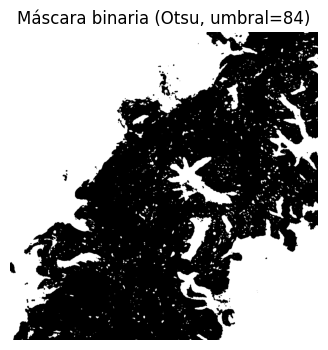

In [6]:
# Aplicar un filtro gaussiano de tamaño 5x5 y después utilizar el método de Otsu de manera que
# los píxeles correspondientes al lumen y al background de la imagen sean 1s y el resto de los píxeles tengan un valor de 0.
# Nota: Recordar que el método de Otsu requiere como input una imagen en el rango [0-255] en formato "uint8".
# Visualizar la máscara resultante


# Paso 1: Aplicar filtro gaussiano 5x5 sobre el canal magenta
magenta_suavizada = gaussian(canal_magenta, sigma=1)  # Aproximadamente 5x5

# Paso 2: Convertir a uint8 en el rango [0, 255]
magenta_uint8 = (magenta_suavizada * 255).astype(np.uint8)

# Paso 3: Aplicar umbral de Otsu
umbral_otsu = threshold_otsu(magenta_uint8)

# Paso 4: Crear máscara binaria (1: lumen/fondo, 0: tejido)
mascara_binaria = magenta_uint8 < umbral_otsu
mascara_binaria = mascara_binaria.astype(np.uint8)  # Para visualización clara

# Paso 5: Visualizar
plt.figure(figsize=(4, 4))
plt.imshow(mascara_binaria, cmap='gray')
plt.axis('off')
plt.title(f'Máscara binaria (Otsu, umbral={umbral_otsu})')
plt.show()


## Alternativa: Aplicación de filtro Gaussiano con kernel 5x5 exacto usando OpenCV

Aunque la función `gaussian()` de `scikit-image` permite controlar el nivel de suavizado mediante el parámetro `sigma`, no permite definir directamente el tamaño del kernel (ventana). Este se calcula automáticamente en función del valor de `σ`.

En algunos casos, puede ser deseable aplicar un kernel Gaussiano con tamaño fijo, por ejemplo, en este caso 5x5, para garantizar una ventana exacta de convolución.

#### Solución: `cv2.GaussianBlur` de OpenCV

La función `GaussianBlur` de OpenCV permite definir explícitamente el tamaño del kernel de suavizado.

- El canal de entrada debe estar en formato `uint8` (rango [0, 255]).
- `cv2.GaussianBlur` permite establecer un `σ` personalizado o dejar que se calcule automáticamente en función del kernel.
- Este método proporciona resultados más consistentes cuando se desea usar un tamaño fijo de ventana.

#### Comparación:

| Método                    | Control de `σ` | Control de kernel | Recomendado cuando...                        |
|---------------------------|----------------|--------------------|-----------------------------------------------|
| `skimage.filters.gaussian`| Si             | Automático     | Se prioriza facilidad y prototipado           |
| `cv2.GaussianBlur`        | Si              | Exacto        | Se necesita precisión en el tamaño del filtro |



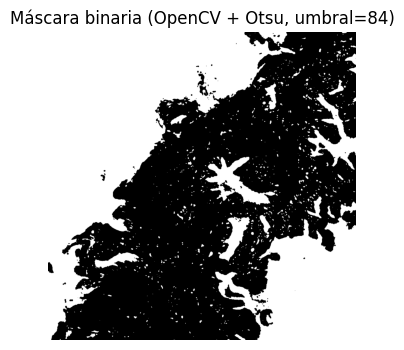

In [7]:
# Paso 1: Convertir canal magenta a rango [0, 255] y tipo uint8
magenta_uint8 = (canal_magenta * 255).astype(np.uint8)

# Paso 2: Aplicar filtro Gaussiano con kernel 5x5
magenta_suavizada_cv2 = cv2.GaussianBlur(magenta_uint8, (5, 5), sigmaX=0)

# Paso 3: Calcular umbral de Otsu
umbral_otsu_cv2 = threshold_otsu(magenta_suavizada_cv2)

# Paso 4: Crear máscara binaria (1: lumen + fondo, 0: tejido)
mascara_cv2 = (magenta_suavizada_cv2 < umbral_otsu_cv2).astype(np.uint8)

# Paso 5: Visualizar máscara
plt.figure(figsize=(4, 4))
plt.imshow(mascara_cv2, cmap='gray')
plt.axis('off')
plt.title(f'Máscara binaria (OpenCV + Otsu, umbral={umbral_otsu_cv2})')
plt.show()


#### Comparación entre máscaras (skimage vs OpenCV)

Se comparan las máscaras generadas por dos métodos:
- `skimage.filters.gaussian` + Otsu
- `cv2.GaussianBlur` (kernel 5x5) + Otsu

La imagen de diferencia muestra la discrepancia entre ambos enfoques. Si la diferencia es cercana a cero, los métodos son equivalentes en la práctica.

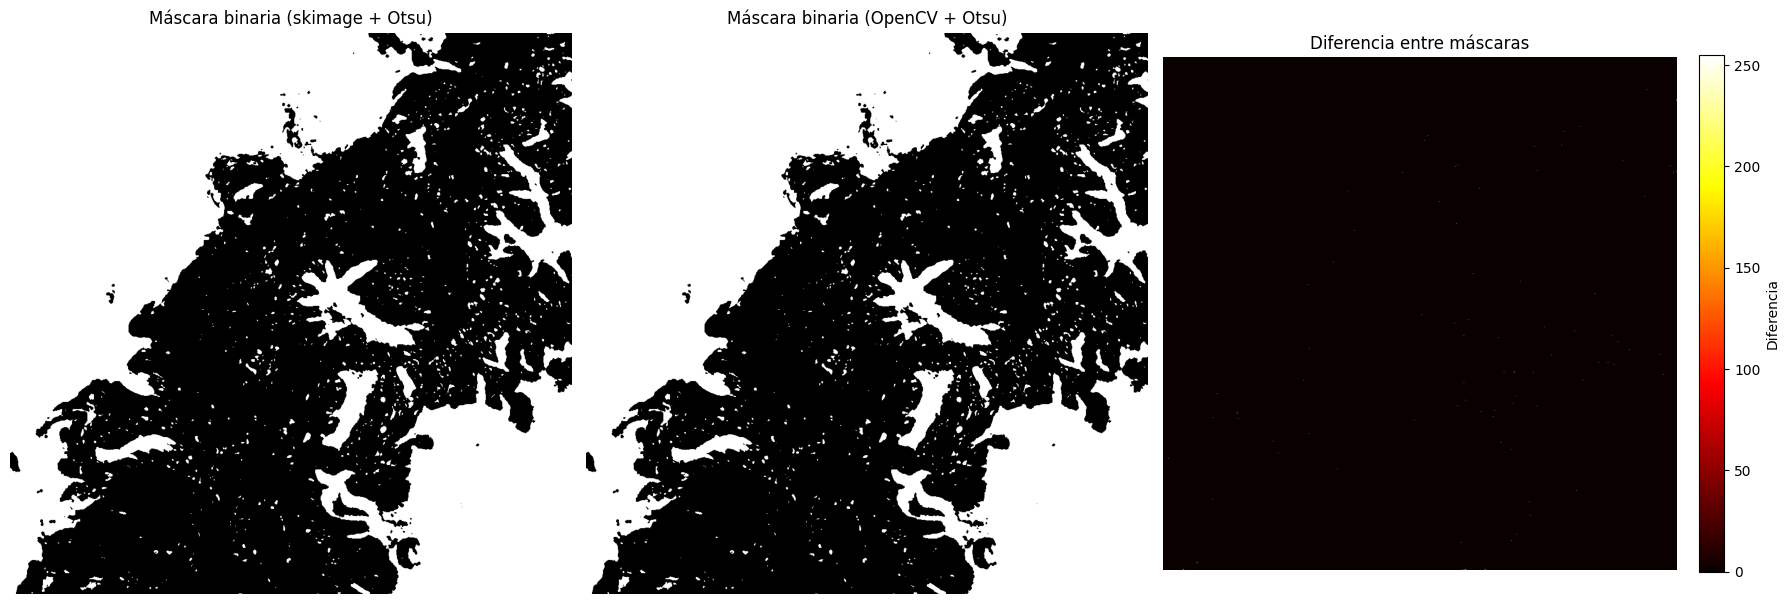

In [8]:

# Asegurar que ambas máscaras tengan el mismo tamaño
if mascara_binaria.shape != mascara_cv2.shape:
    mascara_cv2 = resize(mascara_cv2, mascara_binaria.shape, order=0, preserve_range=True).astype(np.uint8)

# Calcular diferencia absoluta entre máscaras
diferencia_mascaras = np.abs(mascara_binaria - mascara_cv2)

# Visualización comparativa
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(mascara_binaria, cmap='gray')
axs[0].set_title("Máscara binaria (skimage + Otsu)")
axs[0].axis('off')

axs[1].imshow(mascara_cv2, cmap='gray')
axs[1].set_title("Máscara binaria (OpenCV + Otsu)")
axs[1].axis('off')

im = axs[2].imshow(diferencia_mascaras, cmap='hot')
axs[2].set_title("Diferencia entre máscaras")
axs[2].axis('off')

fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04, label='Diferencia')
plt.tight_layout()
plt.show()


#### Resultado de la comparación entre métodos de segmentación

La comparación entre las máscaras binarizadas generadas con:

- `skimage.filters.gaussian` (σ=1) + Otsu
- `cv2.GaussianBlur` (kernel 5x5) + Otsu

muestra que ambos métodos producen resultados prácticamente idénticos. La imagen de diferencia entre máscaras no revela píxeles distintos. Ambos enfoques son válidos para esta tarea de segmentación del canal magenta. Si se requiere precisión en el tamaño del kernel, OpenCV es la opción adecuada. Para un enfoque más directo y didáctico, `skimage` es perfectamente válido.

> En este caso específico, **no hay impacto** en los resultados al usar uno u otro método.


# Limpiar la imagen eliminando los artefactos de lumen (objetos blancos pequeños que no son lúmenes)
Después de segmentar la imagen histológica, es común que aparezcan pequeños objetos blancos (valor `1`) en la máscara binaria que no corresponden a lúmenes reales, sino a ruido o estructuras no deseadas.

#### Objetivo:

Eliminar estos artefactos pequeños utilizando la función `remove_small_objects` de `skimage.morphology`.

#### Procedimiento:

- Se convierte la máscara binaria al tipo `bool`, ya que `remove_small_objects` solo trabaja con imágenes booleanas.
- Se eliminan todos los componentes conectados cuya área sea menor a 300 píxeles.
- Se visualiza la máscara limpia, en la que solo se conservan regiones suficientemente grandes para ser consideradas posibles lúmenes.

> Esta limpieza mejora la calidad del análisis posterior, reduciendo el número de falsos positivos.


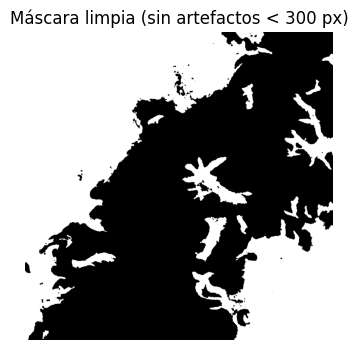

In [9]:
# Utilizar la librería skimage.morphology.remove_small_objects para eliminar aquellos objetos cuya área sea menor a 300 píxeles
# Más información en https://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.remove_small_objects
# Visualizaer la máscara resultante

# Convertir a booleano para usar con remove_small_objects
mascara_bool = mascara_binaria.astype(bool)

# Eliminar objetos menores a 300 píxeles (considerados ruido o artefactos)
mascara_limpia = remove_small_objects(mascara_bool, min_size=300)

# Visualizar la máscara limpia
plt.figure(figsize=(4, 4))
plt.imshow(mascara_limpia, cmap='gray')
plt.axis('off')
plt.title("Máscara limpia (sin artefactos < 300 px)")
plt.show()


# Rellenar con 0s el fondo de la imagen para quedarnos únicamente con los lúmenes

Después de eliminar los artefactos pequeños, es posible que aún queden regiones del fondo conectadas a los bordes de la imagen. En este paso, se aplica un algoritmo de expansión por regiones (region growing) para eliminar por completo el fondo y conservar solo los lúmenes aislados.

#### Objetivo:

- A partir de semillas ubicadas en el fondo (bordes de la imagen), se propaga una región que cubre todo el fondo.
- Se invierte esta región y se aplica como máscara para quedarse solo con los objetos cerrados (lúmenes).

#### Procedimiento:

1. Se invierte la máscara binaria para que el fondo tenga valor `1` y los lúmenes `0`.
2. Se seleccionan dos semillas ubicadas en las esquinas de la imagen (superior izquierda y esquina inferior derecha), bajo la suposición de que son fondo.
3. Se aplica `skimage.segmentation.flood` para propagar desde esas semillas.
4. Se une el resultado de ambas expansiones para obtener la máscara del fondo.
5. Se elimina el fondo de la imagen original aplicando una operación lógica AND con la negación del fondo.

> Este proceso asegura que solo los **lúmenes cerrados y desconectados del borde** permanezcan visibles en la imagen final.


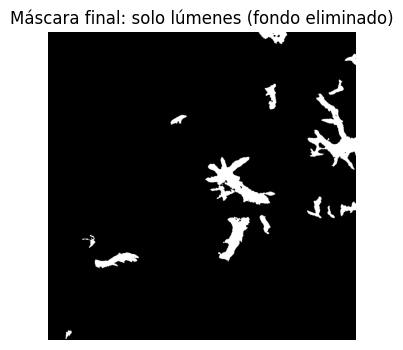

In [10]:
# Aplicar el algoritmo de expansión a partir de semillas (region growing) de manera que únicamente los lúmenes sean blancos
# y el resto de la imagen negra. Pista: utilizar dos semillas. Nota: Se pueden fijar las semillas de manera manual, pero
# se valorará positivamente a aquell@s que desarrollen una función para encontrarlas automáticamente.
# Visualizar la máscara resultante. 

# Invertimos la máscara: fondo = 1, lúmenes = 0
inversa = ~mascara_limpia

# Semillas: esquinas (suponemos que están en el fondo)
semilla_1 = (0, 0)
semilla_2 = (mascara_limpia.shape[0] - 1, mascara_limpia.shape[1] - 1)

# Aplicar expansión por regiones desde cada semilla
region_1 = flood(inversa, seed_point=semilla_1)
region_2 = flood(inversa, seed_point=semilla_2)

# Fondo total = unión de ambas regiones
fondo = region_1 | region_2

# Resultado final: conservar solo los lúmenes (descartando fondo)
mascara_final = mascara_limpia & (~fondo)

# Visualizar resultado
plt.figure(figsize=(4, 4))
plt.imshow(mascara_final, cmap='gray')
plt.axis('off')
plt.title("Máscara final: solo lúmenes (fondo eliminado)")
plt.show()


### Alternativa Automática con Expansión de Bordes

Este procedimiento tiene como objetivo separar los lúmenes del fondo en una imagen binaria de tejido histológico. Se aplica una estrategia automática para evitar depender de semillas manuales, asegurando así robustez frente a imágenes variadas.

#### Pasos realizados:

1. **Expansión con borde blanco:**
   Se agrega un borde de 1 píxel con valor `1` (blanco) a todos los lados de la máscara binaria, garantizando que el fondo esté conectado a los bordes.

2. **Inversión de la imagen:**
   Se invierte la imagen para que el fondo (antes blanco) tenga valor `0`, y los lúmenes pasen a `1`, preparándola para el algoritmo de expansión.

3. **Selección automática de semillas:**
   Se utilizan dos puntos fijos en las esquinas (superior izquierda e inferior derecha) como semillas. Estas zonas suelen estar en el fondo de la imagen expandida.

4. **Expansión regional (`region growing`):**
   Se aplica expansión desde ambas semillas para identificar todas las zonas conectadas al fondo.

5. **Eliminación del fondo:**
   Se crea una nueva máscara que contiene únicamente los lúmenes (excluyendo el fondo detectado).

6. **Recorte del borde:**
   Se recorta el borde añadido inicialmente, restaurando el tamaño original de la imagen.

Este método permite una segmentación robusta y automática de los lúmenes, ideal para procesamientos por lotes o flujos sin intervención manual.

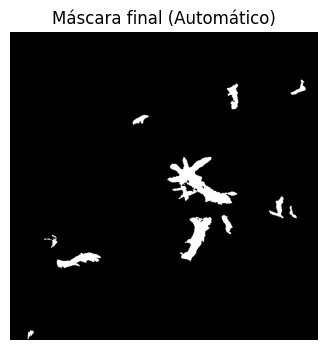

In [11]:
# 1. Expandir la imagen binaria con borde blanco (1) ---

def expandir_con_borde(imagen_binaria):
    """
    Expande la imagen binaria añadiendo un borde blanco (valor 1) de 1 píxel por lado.
    """
    return np.pad(imagen_binaria, pad_width=1, mode='constant', constant_values=1)

# Expandir la máscara limpia
mascara_limpia_expandida = expandir_con_borde(mascara_limpia)

# 2. Invertir la imagen (fondo pasa a 0, lúmenes a 1) ---

inversa_expandida = ~mascara_limpia_expandida

# 3. Usar dos esquinas como semillas (superior izq y inferior der) ---

semillas = [(0, 0), (inversa_expandida.shape[0] - 1, inversa_expandida.shape[1] - 1)]

# 4. Aplicar region growing desde ambas semillas ---

fondo_expandido = np.zeros_like(inversa_expandida, dtype=bool)
for semilla in semillas:
    fondo_expandido |= flood(inversa_expandida, seed_point=semilla)

# 5. Eliminar fondo (regiones conectadas desde las esquinas) ---

mascara_final_expandida = mascara_limpia_expandida & (~fondo_expandido)

# 6. Recortar para eliminar el borde añadido ---

mascara_final_auto = mascara_final_expandida[1:-1, 1:-1]  # Eliminar borde de 1 píxel

# 7. Visualizar resultado final ---

plt.figure(figsize=(4, 4))
plt.imshow(mascara_final_auto, cmap='gray')
plt.axis('off')
plt.title("Máscara final (Automático)")
plt.show()


# Rellenar los objetos de los lúmenes

Una vez obtenidas las máscaras segmentadas (tanto manual como automáticamente), es importante asegurarse de que los lúmenes estén completamente cerrados, sin agujeros internos. Esto se logra mediante la función `binary_fill_holes` de `scipy.ndimage`.

#### Objetivo:

Rellenar huecos internos en los objetos binarios identificados como lúmenes, asegurando que cada uno sea una región sólida y completamente conectada.

#### Procedimiento:

1. Se aplica `binary_fill_holes` a ambas máscaras finales:
   - La generada con semillas manuales.
   - La generada automáticamente.
2. Se visualizan ambas imágenes para verificar que los objetos han sido rellenados correctamente.
3. Se calcula y muestra una imagen de diferencia absoluta entre ambas versiones para comparar resultados.

#### Análisis:

La visualización simultánea permite verificar si ambas estrategias de detección de fondo y segmentación conducen a resultados equivalentes tras el relleno. Una imagen de diferencia oscura sugiere que ambas versiones son consistentes.

> Este paso es crucial para garantizar la calidad de los descriptores geométricos que se calcularán en la siguiente fase.


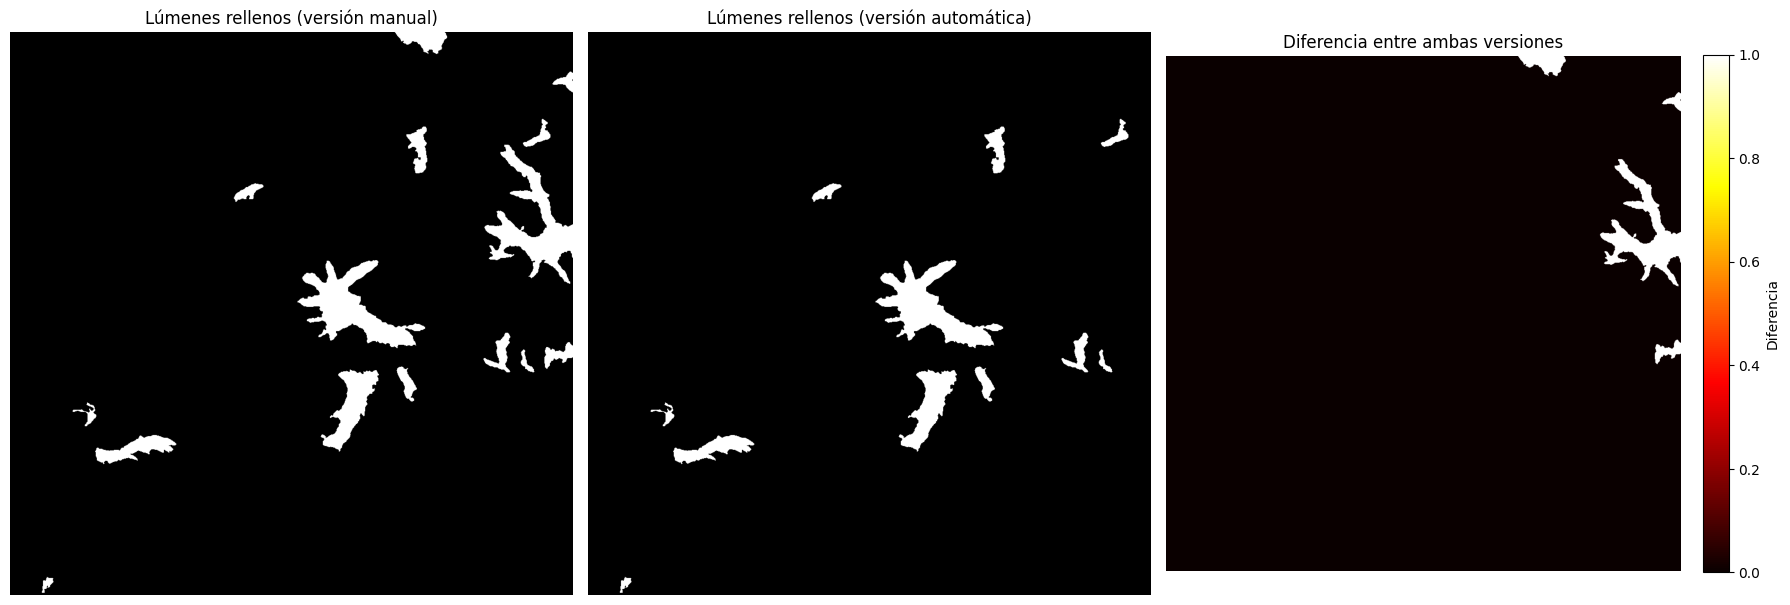

In [12]:
# Rellenar huecos internos en ambas máscaras
rellena_manual = binary_fill_holes(mascara_final)
rellena_auto = binary_fill_holes(mascara_final_auto)

# Calcular diferencia entre ambas (opcional)
diferencia = np.abs(rellena_manual.astype(int) - rellena_auto.astype(int))

# Visualizar resultados
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(rellena_manual, cmap='gray')
axs[0].set_title("Lúmenes rellenos (versión manual)")
axs[0].axis('off')

axs[1].imshow(rellena_auto, cmap='gray')
axs[1].set_title("Lúmenes rellenos (versión automática)")
axs[1].axis('off')

axs[2].imshow(diferencia, cmap='hot')
axs[2].set_title("Diferencia entre ambas versiones")
axs[2].axis('off')

fig.colorbar(axs[2].images[0], ax=axs[2], fraction=0.046, pad=0.04, label='Diferencia')
plt.tight_layout()
plt.show()


# Detectar y dibujar los contornos de los lúmenes sobre la imagen original

Con las máscaras de lúmenes ya rellenas, se procede a detectar los contornos de cada objeto identificado y dibujarlos sobre la imagen histológica original. Esto permite validar visualmente la calidad de la segmentación realizada.

#### Objetivo:

- Resaltar los límites de los lúmenes detectados sobre la imagen original RGB, utilizando un trazo de color verde para facilitar su visibilidad.
- Comparar los resultados obtenidos con la segmentación basada en semillas manuales y automáticas.

#### Procedimiento:

1. Se utiliza `find_contours` de `skimage.measure` para detectar los bordes de cada región conectada con valor `1` en la máscara binaria.
2. Se recorren las coordenadas de cada contorno y se sobrescriben en verde (`[0, 1, 0]`) directamente sobre una copia de la imagen original.
3. Se visualizan las dos versiones de la imagen:
   - Contornos generados desde la versión manual.
   - Contornos generados desde la versión automática.

#### Análisis:

Esta superposición permite verificar si los lúmenes detectados corresponden con las estructuras reales en la imagen histológica. Una buena segmentación tendrá contornos que coincidan bien con los bordes visibles de los lúmenes.

> Esta validación visual es clave antes de aplicar descriptores geométricos o tomar decisiones de clasificación.

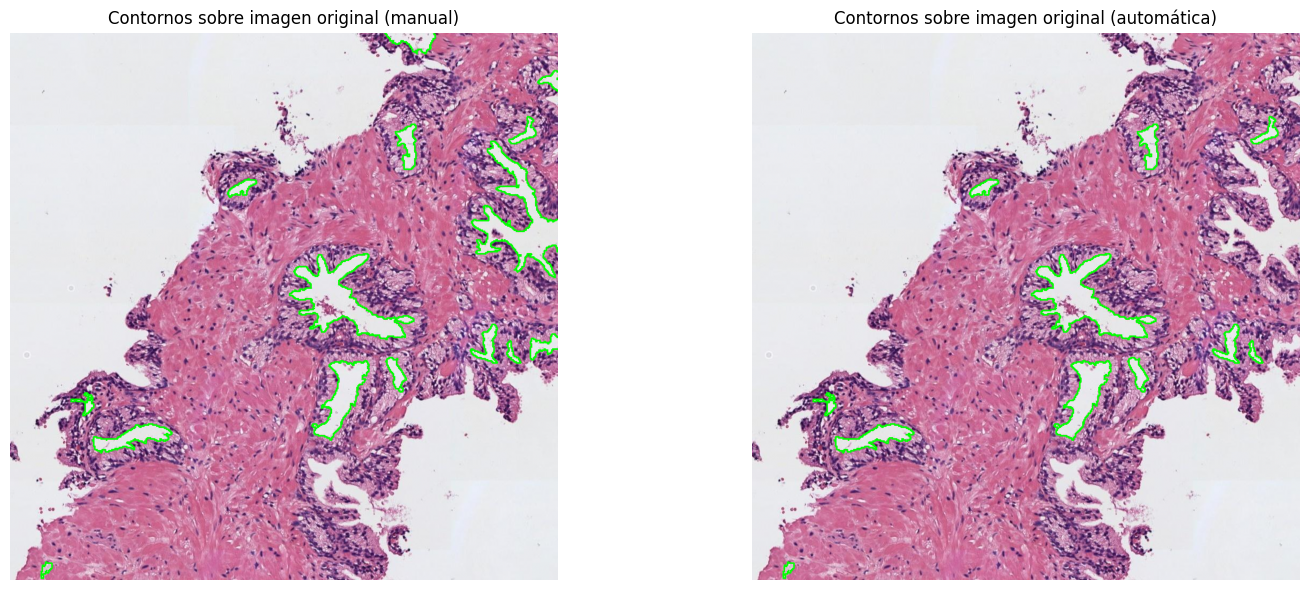

In [13]:
# Dibujar los contornos de los lúmenes en color verde sobre la imagen original RGB. Nota: Utilizar los flags necesarios
# para que los contornos en verde sean perfectamente visibles. 
# Visualizar la imagen superpuesta


def dibujar_contornos(imagen_rgb, mascara, color=(0, 1, 0), grosor=2):
    """
    Dibuja los contornos de una máscara sobre una imagen RGB.
    color: tupla RGB en [0, 1]
    grosor: número de píxeles alrededor del borde
    """


    imagen_contorno = imagen_rgb.copy()
    contornos = find_contours(mascara, level=0.5)

    for contorno in contornos:
        contorno = np.round(contorno).astype(int)
        for y, x in contorno:
            if 0 <= y < imagen_contorno.shape[0] and 0 <= x < imagen_contorno.shape[1]:
                rr, cc = disk((y, x), radius=grosor, shape=imagen_contorno.shape[:2])
                imagen_contorno[rr, cc] = color

    return imagen_contorno


# Aplicar a ambas versiones
contorno_manual = dibujar_contornos(imagen, rellena_manual, color=(0, 1, 0), grosor=2)
contorno_auto = dibujar_contornos(imagen, rellena_auto, color=(0, 1, 0), grosor=2)


# Mostrar comparación
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].imshow(contorno_manual)
axs[0].set_title("Contornos sobre imagen original (manual)")
axs[0].axis('off')

axs[1].imshow(contorno_auto)
axs[1].set_title("Contornos sobre imagen original (automática)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


# Identificar y cropear el lumen más grande

Con la máscara binaria final (rellena), se procede a identificar el lumen con mayor área y a recortarlo directamente sobre la imagen histológica original en color. Esto permite analizar de manera detallada la morfología de un lumen representativo.

#### Objetivo:

- Detectar el lumen más grande en cada una de las dos versiones (manual y automática).
- Obtener su bounding box y extraer esa región de la imagen original RGB.
- Comparar visualmente ambos recortes.

#### Procedimiento:

1. Se etiquetan todas las regiones conectadas en la máscara binaria rellena.
2. Se calcula el área de cada región utilizando `regionprops`.
3. Se selecciona la región con mayor área.
4. Se extrae su bounding box y se hace un crop sobre la imagen RGB original.
5. Se visualizan el recorte de la versión manual y automática.

> Este análisis es útil para comparar directamente la precisión y consistencia de ambos métodos de segmentación.


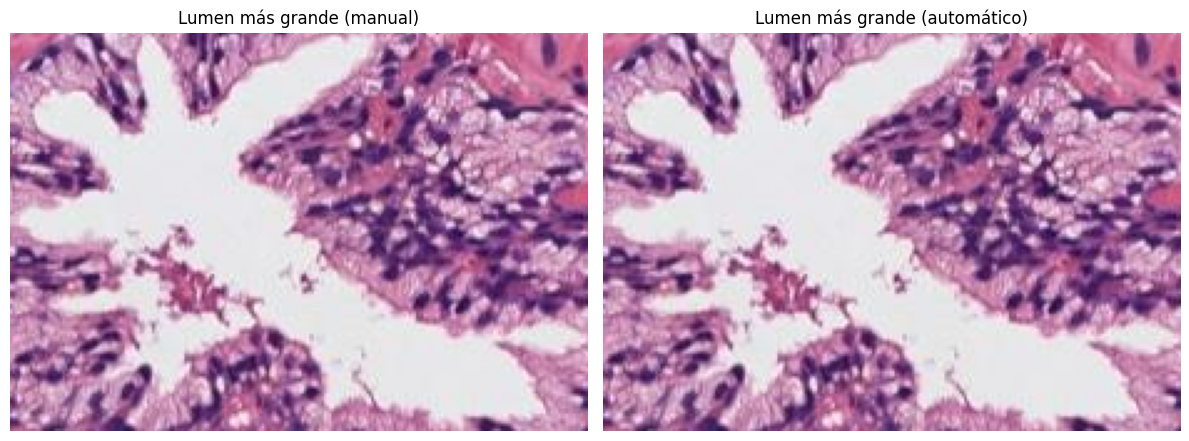

In [14]:
# Determinar cuál es el lumen de mayor área y hacer un crop del mismo sobre la imagen original RGB.
# Visualizar el lumen cropeado.


def cropear_lumen_mas_grande(mascara_rellena, imagen_rgb):
    """
    Detecta el lumen más grande en la máscara y lo recorta de la imagen RGB original.
    Retorna la imagen recortada (crop).
    """
    etiquetas = label(mascara_rellena)
    regiones = regionprops(etiquetas)

    if not regiones:
        return None  # No hay lúmenes detectados

    region_max = max(regiones, key=lambda r: r.area)
    minr, minc, maxr, maxc = region_max.bbox

    return imagen_rgb[minr:maxr, minc:maxc, :]

# Aplicar a ambas versiones
crop_manual = cropear_lumen_mas_grande(rellena_manual, imagen)
crop_auto = cropear_lumen_mas_grande(rellena_auto, imagen)

# Visualizar ambos crops
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

if crop_manual is not None:
    axs[0].imshow(crop_manual)
    axs[0].set_title("Lumen más grande (manual)")
    axs[0].axis('off')
else:
    axs[0].text(0.5, 0.5, 'Sin lumen', ha='center', va='center')
    axs[0].set_title("Manual")
    axs[0].axis('off')

if crop_auto is not None:
    axs[1].imshow(crop_auto)
    axs[1].set_title("Lumen más grande (automático)")
    axs[1].axis('off')
else:
    axs[1].text(0.5, 0.5, 'Sin lumen', ha='center', va='center')
    axs[1].set_title("Automático")
    axs[1].axis('off')

plt.tight_layout()
plt.show()


# Extraer 13 características geométricas que permitan caracterizar el lumen recortado 

En este paso se cuantifica la forma del lumen más grande utilizando descriptores geométricos, fundamentales para distinguir patrones estructurales entre tejidos sanos y cancerígenos.

#### Objetivo:

Calcular 13 características que describen la forma, tamaño y orientación del lumen, a partir de su máscara binaria rellena. Se realiza la comparación para ambos métodos de segmentación: manual y automático.

#### Características calculadas:

1. **Área**: Número de píxeles del lumen.
2. **Área de la bounding box**: Área del rectángulo que contiene completamente al lumen.
3. **Área convexa**: Área de la envolvente convexa del lumen.
4. **Excentricidad**: Qué tan alargada es la figura (0=circular, 1=una línea).
5. **Diámetro equivalente**: Diámetro de un círculo con igual área.
6. **Extensión**: Relación entre el área del lumen y la del bounding box.
7. **Diámetro Feret**: Distancia máxima entre puntos del contorno.
8. **Longitud del eje mayor**: Eje mayor de la elipse ajustada.
9. **Longitud del eje menor**: Eje menor de la elipse ajustada.
10. **Orientación**: Ángulo de inclinación del eje mayor respecto al eje horizontal.
11. **Perímetro**: Longitud del contorno del lumen.
12. **Solidez**: Relación entre el área y el área convexa.
13. **Compacidad**: Medida de redondez: (perímetro²) / área.

#### Visualización:

Los resultados se presentan en una tabla comparativa (heatmap), donde cada fila representa un método (manual o automático) y cada columna una característica. Esto permite observar similitudes o diferencias significativas en la segmentación realizada.

> Esta información es clave para entrenar clasificadores que diferencien entre tejidos sanos y con patologías, basándose en la geometría de los lúmenes.


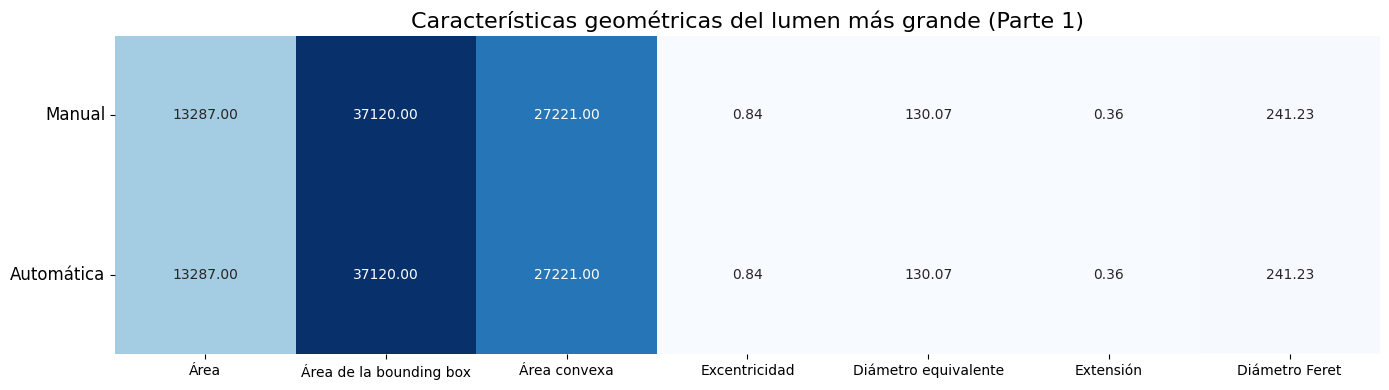

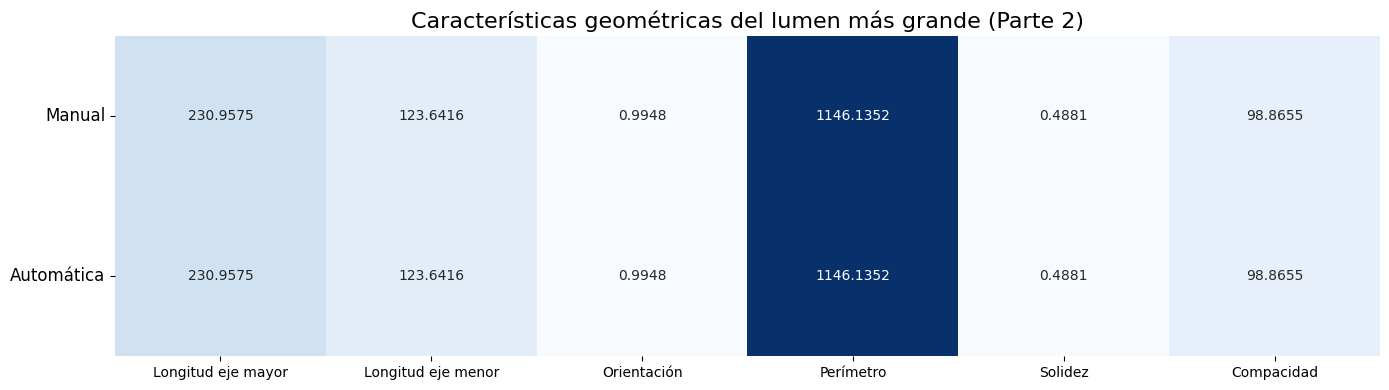

In [44]:

def calcular_caracteristicas(mascara_rellena):
    """
    Calcula las 13 características geométricas del lumen más grande.
    Retorna un diccionario con los valores redondeados a 4 decimales.
    """
    etiquetas = label(mascara_rellena)
    regiones = regionprops(etiquetas)

    if not regiones:
        return {}

    # Región con mayor área
    region = max(regiones, key=lambda r: r.area)

    # Calcular algunas propiedades
    area = region.area
    area_bbox = region.bbox_area
    area_convexa = region.convex_area
    excentricidad = region.eccentricity
    diam_equivalente = region.equivalent_diameter
    extension = region.extent
    eje_mayor = region.major_axis_length
    eje_menor = region.minor_axis_length
    orientacion = region.orientation
    perimetro = region.perimeter
    solidez = region.solidity

    # Diámetro de Feret (distancia máxima entre puntos del contorno)
    coords = region.coords
    try:
        hull = ConvexHull(coords)
        feret = max(np.linalg.norm(coords[i] - coords[j])
                    for i in hull.vertices for j in hull.vertices)
    except:
        feret = 0

    # Compacidad = (Perímetro^2) / Área
    compacidad = (perimetro ** 2) / area if area > 0 else 0

    # Empaquetar resultados
    resultados = {
        "Área": round(area, 4),
        "Área de la bounding box": round(area_bbox, 4),
        "Área convexa": round(area_convexa, 4),
        "Excentricidad": round(excentricidad, 4),
        "Diámetro equivalente": round(diam_equivalente, 4),
        "Extensión": round(extension, 4),
        "Diámetro Feret": round(feret, 4),
        "Longitud eje mayor": round(eje_mayor, 4),
        "Longitud eje menor": round(eje_menor, 4),
        "Orientación": round(orientacion, 4),
        "Perímetro": round(perimetro, 4),
        "Solidez": round(solidez, 4),
        "Compacidad": round(compacidad, 4)
    }

    return resultados

# Aplicar a ambas versiones
carac_manual = calcular_caracteristicas(rellena_manual)
carac_auto = calcular_caracteristicas(rellena_auto)

# Mostrar resultados

df = pd.DataFrame([carac_manual, carac_auto], index=['Manual', 'Automática'])


# Parte 1: primeras 7 columnas
df_parte1 = df.iloc[:, :7]
plt.figure(figsize=(14, 4))
sns.heatmap(df_parte1, annot=True, fmt=".2f", cmap="Blues", cbar=False, annot_kws={"fontsize": 10})
plt.title("Características geométricas del lumen más grande (Parte 1)", fontsize=16)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.tight_layout()
plt.show()

# Parte 2: siguientes 6 columnas
df_parte2 = df.iloc[:, 7:]
plt.figure(figsize=(14, 4))
sns.heatmap(df_parte2, annot=True, fmt=".4f", cmap="Blues", cbar=False, annot_kws={"fontsize": 10})
plt.title("Características geométricas del lumen más grande (Parte 2)", fontsize=16)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=0, ha='center', fontsize=10)
plt.tight_layout()
plt.show()


# Clase Definitiva

In [30]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from scipy.ndimage import binary_fill_holes
from scipy.spatial import ConvexHull
from skimage import io
from skimage.draw import disk
from skimage.filters import threshold_otsu, gaussian
from skimage.measure import find_contours, regionprops, label
from skimage.morphology import remove_small_objects
from skimage.segmentation import flood

class AnalizadorLumen:
    """
    Clase para analizar imágenes histológicas y extraer características geométricas de los lúmenes.

    Atributos:
        ruta_imagen (str): Ruta al archivo de imagen.
    """
    def __init__(self, ruta_imagen):
        """
        Inicializa el objeto y ejecuta todo el pipeline de procesamiento y análisis.

        Args:
            ruta_imagen (str): Ruta a la imagen histológica.
        """
        self.ruta_imagen = ruta_imagen
        self.imagen = self._leer_y_normalizar()
        self.canal_magenta = 1 - self.imagen[:, :, 1]
        self.mascara_binaria = self._segmentar()
        self.mascara_limpia = remove_small_objects(self.mascara_binaria.astype(bool), min_size=300)
        self.mascara_final = self._region_growing_manual()
        self.mascara_final_auto = self._region_growing_automatico()
        self.rellena_manual = binary_fill_holes(self.mascara_final)
        self.rellena_auto = binary_fill_holes(self.mascara_final_auto)
        self.contorno_manual = self._dibujar_contornos(self.rellena_manual)
        self.contorno_auto = self._dibujar_contornos(self.rellena_auto)
        self.crop_manual = self._cropear_lumen(self.rellena_manual)
        self.crop_auto = self._cropear_lumen(self.rellena_auto)
        self.carac_manual = self._calcular_caracteristicas(self.rellena_manual)
        self.carac_auto = self._calcular_caracteristicas(self.rellena_auto)

    def _leer_y_normalizar(self):
        """
        Lee la imagen y la normaliza al rango [0, 1].

        Returns:
            np.ndarray: Imagen normalizada.
        """
        img = io.imread(self.ruta_imagen)
        return (img - img.min()) / (img.max() - img.min())

    def _segmentar(self):
        """
        Segmenta la imagen usando filtro Gaussiano y umbral de Otsu.

        Returns:
            np.ndarray: Máscara binaria resultante.
        """
        suavizada = gaussian(self.canal_magenta, sigma=1)
        magenta_uint8 = (suavizada * 255).astype(np.uint8)
        umbral = threshold_otsu(magenta_uint8)
        return (magenta_uint8 < umbral).astype(np.uint8)

    def _region_growing_manual(self):
        """
        Aplica expansión desde semillas manuales para eliminar el fondo.

        Returns:
            np.ndarray: Máscara final binaria (manual).
        """
        inversa = ~self.mascara_limpia
        semillas = [(0, 0), (self.mascara_limpia.shape[0] - 1, self.mascara_limpia.shape[1] - 1)]
        fondo = np.zeros_like(inversa, dtype=bool)
        for semilla in semillas:
            fondo |= flood(inversa, seed_point=semilla)
        return self.mascara_limpia & (~fondo)

    def _region_growing_automatico(self):
        """
        Realiza una expansión automática del fondo añadiendo bordes.

        Returns:
            np.ndarray: Máscara final binaria (automática).
        """
        def expandir_con_borde(img):
            """
            Añade un borde blanco (valor 1) de 1 píxel alrededor de la imagen.
            """
            return np.pad(img, pad_width=1, mode='constant', constant_values=1)

        expandida = expandir_con_borde(self.mascara_limpia)
        inversa = ~expandida
        semillas = [(0, 0), (inversa.shape[0] - 1, inversa.shape[1] - 1)]
        fondo = np.zeros_like(inversa, dtype=bool)
        for semilla in semillas:
            fondo |= flood(inversa, seed_point=semilla)
        return (expandida & (~fondo))[1:-1, 1:-1]

    def _dibujar_contornos(self, mascara, color=(0, 1, 0), grosor=2):
        """
        Dibuja contornos sobre la imagen original.

        Args:
            mascara (np.ndarray): Máscara binaria con el objeto.
            color (tuple): Color RGB en rango [0,1].
            grosor (int): Grosor del contorno en píxeles.

        Returns:
            np.ndarray: Imagen con contornos dibujados.
        """
        imagen_contorno = self.imagen.copy()
        contornos = find_contours(mascara, level=0.5)
        for contorno in contornos:
            contorno = np.round(contorno).astype(int)
            for y, x in contorno:
                if 0 <= y < imagen_contorno.shape[0] and 0 <= x < imagen_contorno.shape[1]:
                    rr, cc = disk((y, x), radius=grosor, shape=imagen_contorno.shape[:2])
                    imagen_contorno[rr, cc] = color
        return imagen_contorno

    def _cropear_lumen(self, mascara):
        """
        Corta el lumen más grande de la imagen.

        Args:
            mascara (np.ndarray): Máscara binaria del lumen.

        Returns:
            np.ndarray: Imagen recortada del lumen más grande.
        """
        etiquetas = label(mascara)
        regiones = regionprops(etiquetas)
        if not regiones:
            return None
        region_max = max(regiones, key=lambda r: r.area)
        minr, minc, maxr, maxc = region_max.bbox
        return self.imagen[minr:maxr, minc:maxc, :]

    def _calcular_caracteristicas(self, mascara):
        """
        Calcula características geométricas del lumen más grande.

        Args:
            mascara (np.ndarray): Máscara binaria del lumen.

        Returns:
            dict: Diccionario con 13 características geométricas.
        """
        etiquetas = label(mascara)
        regiones = regionprops(etiquetas)
        if not regiones:
            return {}
        region = max(regiones, key=lambda r: r.area)
        area = region.area
        perimetro = region.perimeter
        try:
            hull = ConvexHull(region.coords)
            feret = max(np.linalg.norm(region.coords[i] - region.coords[j])
                        for i in hull.vertices for j in hull.vertices)
        except:
            feret = 0
        compacidad = (perimetro ** 2) / area if area > 0 else 0
        return {
            "Área": round(area, 4),
            "Área de la bounding box": round(region.bbox_area, 4),
            "Área convexa": round(region.convex_area, 4),
            "Excentricidad": round(region.eccentricity, 4),
            "Diámetro equivalente": round(region.equivalent_diameter, 4),
            "Extensión": round(region.extent, 4),
            "Diámetro Feret": round(feret, 4),
            "Longitud eje mayor": round(region.major_axis_length, 4),
            "Longitud eje menor": round(region.minor_axis_length, 4),
            "Orientación": round(region.orientation, 4),
            "Perímetro": round(perimetro, 4),
            "Solidez": round(region.solidity, 4),
            "Compacidad": round(compacidad, 4)
        }

    def obtener_imagenes_resultado(self):
        """
        Retorna todas las imágenes resultado del análisis.

        Returns:
            dict: Diccionario con imágenes clave del análisis.
        """
        return {
            "manual":{ 
                "contorno":self.contorno_manual,
                "crop": self.crop_manual,
                "relleno": self.rellena_manual,
                },
            "auto":{
                "contorno": self.contorno_auto,
                "crop": self.crop_auto,
                "relleno": self.rellena_auto
                }
        }

    def obtener_caracteristicas_df(self):
        """
        Retorna las características geométricas en formato DataFrame.

        Returns:
            pd.DataFrame: Características manuales y automáticas.
        """
        return pd.DataFrame([self.carac_manual, self.carac_auto], index=["Manual", "Automática"]).T


#### Ejemplo de Uso

In [63]:

def visualizar_imagenes_resultado(imagenes_dict):
    """
    Visualiza las 6 imágenes contenidas en el diccionario estructurado por versión ('manual' y 'auto') 
    y tipo de resultado ('contorno', 'relleno', 'crop').

    Parámetros:
    -----------
    imagenes_dict : dict
        Diccionario con la estructura:
        {
            'manual': {
                'contorno': np.array,
                'relleno': np.array,
                'crop': np.array
            },
            'auto': {
                'contorno': np.array,
                'relleno': np.array,
                'crop': np.array
            }
        }

    Retorna:
    --------
    None. Muestra las imágenes en un grid 2x3.
    """

    titulos = [
        "Contornos Manual",
        "Relleno Manual",
        "Crop Manual",
        "Contornos Automático",
        "Relleno Automático",
        "Crop Automático"
    ]

    # Orden en la que se mostrará cada imagen
    orden = [
        imagenes_dict["manual"]["contorno"],
        imagenes_dict["manual"]["relleno"],
        imagenes_dict["manual"]["crop"],
        imagenes_dict["auto"]["contorno"],
        imagenes_dict["auto"]["relleno"],
        imagenes_dict["auto"]["crop"]
    ]

    plt.figure(figsize=(15, 8))
    for i, (imagen, titulo) in enumerate(zip(orden, titulos)):
        plt.subplot(2, 3, i + 1)
        if imagen is not None:
            if len(imagen.shape) == 3:
                plt.imshow(imagen)
            else:
                plt.imshow(imagen, cmap='gray')
            plt.title(titulo)
        else:
            plt.text(0.5, 0.5, 'No disponible', ha='center', va='center')
            plt.title(titulo)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


import matplotlib.pyplot as plt
import seaborn as sns

def visualizar_heatmaps_caracteristicas(df_caract, dividir_en_dos=True):
    """
    Visualiza los heatmaps de las características geométricas del lumen más grande
    para múltiples imágenes usando un DataFrame con MultiIndex en columnas.

    Parámetros:
    ------------
    df_caract : pd.DataFrame
        DataFrame con columnas jerárquicas (MultiIndex) como ("Histo 1", "Manual").

    dividir_en_dos : bool
        Si True, divide el heatmap en dos partes para mejor visualización (7 y 6 características).

    Retorna:
    --------
    None. Muestra uno o dos heatmaps.
    """
    if dividir_en_dos and df_caract.shape[0] > 7:
        df_parte1 = df_caract.iloc[:7]
        df_parte2 = df_caract.iloc[7:]

        # Heatmap Parte 1
        plt.figure(figsize=(14, 5))
        sns.heatmap(df_parte1, annot=True, fmt=".4f", cmap="Greens", cbar=False,
                    linewidths=0.5, linecolor='gray', annot_kws={"fontsize": 12})
        plt.title("Características geométricas (Parte 1)", fontsize=16)
        plt.yticks(rotation=0, fontsize=12)
        plt.xticks(rotation=0, ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()

        # Heatmap Parte 2
        plt.figure(figsize=(14, 5))
        sns.heatmap(df_parte2, annot=True, fmt=".4f", cmap="Greens", cbar=False,
                    linewidths=0.5, linecolor='gray', annot_kws={"fontsize": 12})
        plt.title("Características geométricas (Parte 2)", fontsize=16)
        plt.yticks(rotation=0, fontsize=12)
        plt.xticks(rotation=0, ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(14, 6))
        sns.heatmap(df_caract, annot=True, fmt=".4f", cmap="Greens", cbar=False,
                    linewidths=0.5, linecolor='gray', annot_kws={"fontsize": 12})
        plt.title("Características geométricas del lumen más grande", fontsize=16)
        plt.yticks(rotation=0, fontsize=12)
        plt.xticks(rotation=0, ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()


#### Resultados Finales

Resultados de la Imagen 1


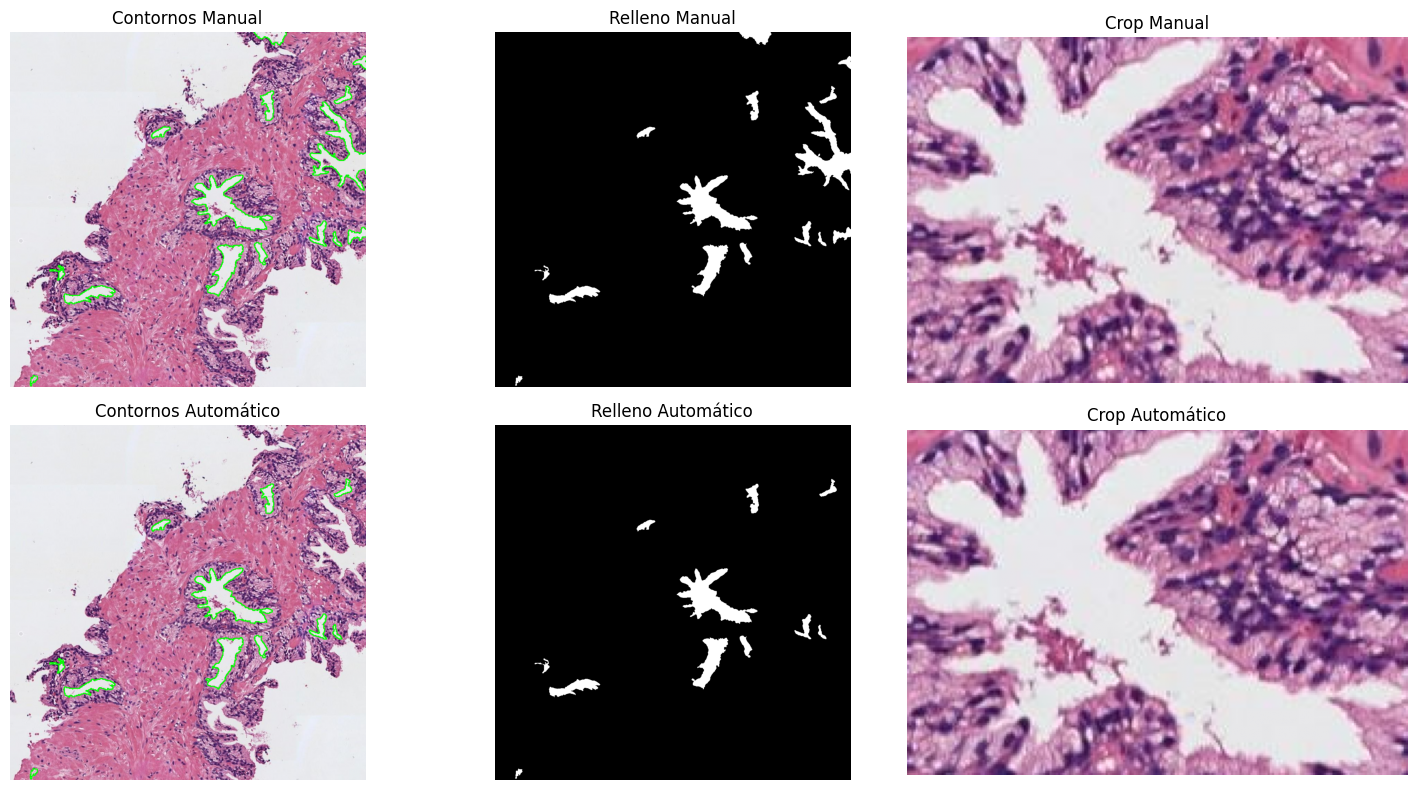

Resultados de la Imagen 2


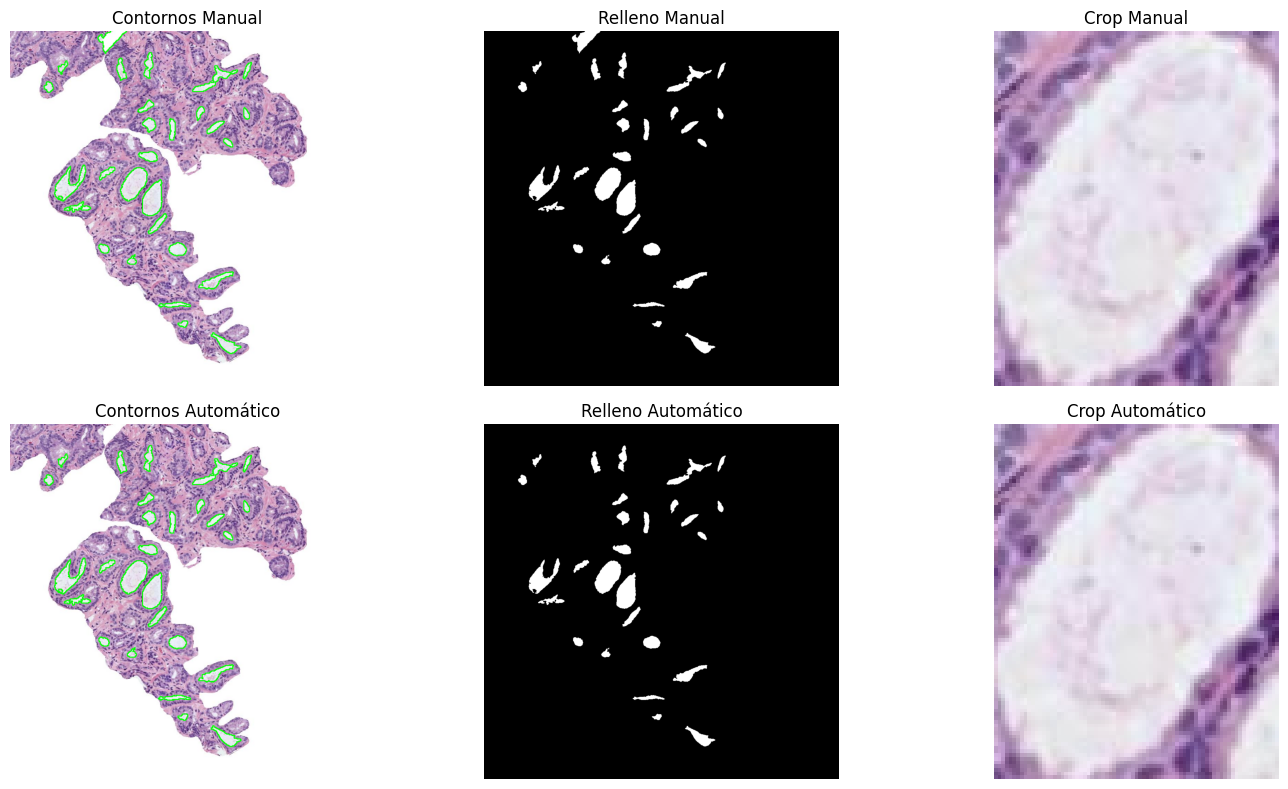

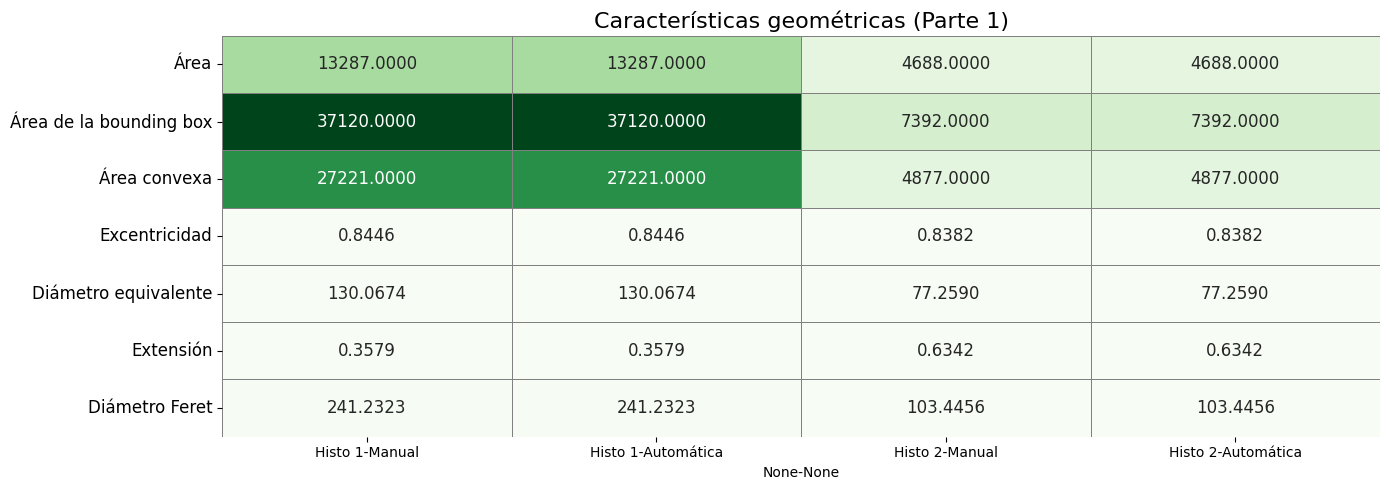

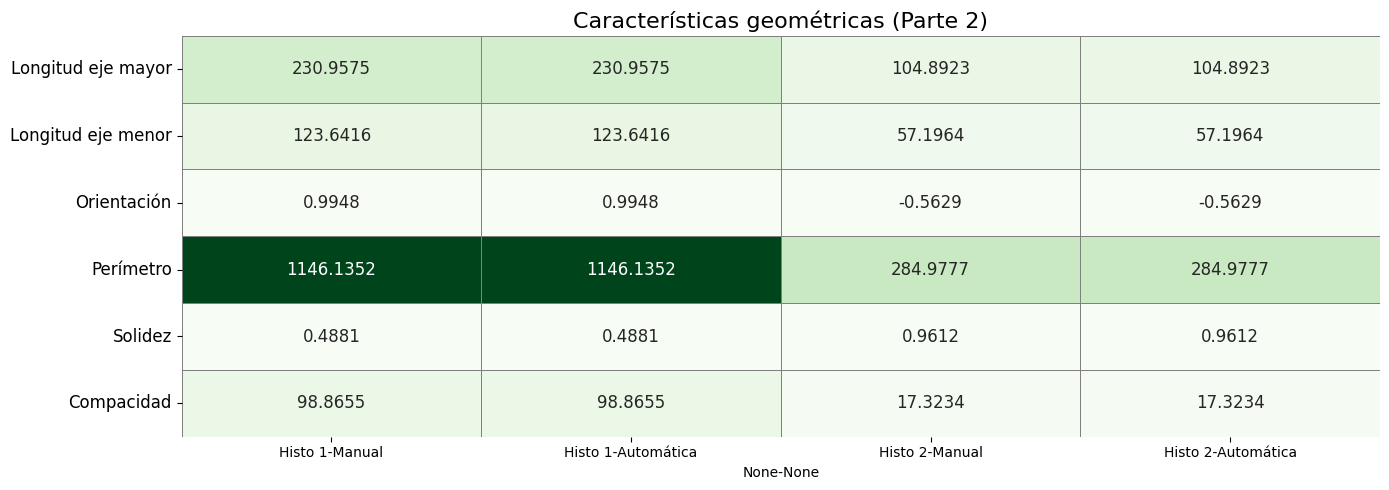

In [65]:
modelo_1 = AnalizadorLumen('histo_1.jpg')
imagenes_h1 = modelo_1.obtener_imagenes_resultado()

modelo_2 = AnalizadorLumen('histo_2.jpg')
imagenes_h2 = modelo_2.obtener_imagenes_resultado()
print("Resultados de la Imagen 1")
visualizar_imagenes_resultado(imagenes_h1)
print("Resultados de la Imagen 2")
visualizar_imagenes_resultado(imagenes_h2)

caracteristicas_h1 = modelo_1.obtener_caracteristicas_df()
caracteristicas_h2 = modelo_2.obtener_caracteristicas_df()

caracteristicas=pd.concat([caracteristicas_h1, caracteristicas_h2], axis=1, keys=["Histo 1", "Histo 2"])
visualizar_heatmaps_caracteristicas(caracteristicas)


Cuando los valores (colores) son iguales entre el análisis manual y automático de una imagen, significa que por los dos métodos se llegó a analizar un mismo elemento. Por otro lado, la diferencia de valores (colores) entre diferentes imágenes, simbolizan posibles factores que podrían indicar la presencia de la enfermedad.